## Predicting CTR - Deploy your model as Endpoint

This notebook provides the steps to build XGBoost model, train it and deploy it as SageMaker endpoint and making predictions using the endpoint.

In [ ]:
!pip install -U sagemaker

In [ ]:
!pip install xgboost

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import TargetEncoder, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix
import xgboost as xgb
# import lightgbm as lgb
import json
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import resample

In [4]:
import os
import boto3
import re
import sagemaker

role = sagemaker.get_execution_role()

session = sagemaker.Session()

region = session.boto_region_name
bucket = session.default_bucket()
prefix = "sagemaker/xgboost-script"

print("Region ",region)
print("Bucket ",bucket)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Region  us-east-1
Bucket  sagemaker-us-east-1-995541965594


In [11]:
df = pd.read_csv('train.csv')

In [12]:
df.columns

Index(['session_id', 'DateTime', 'user_id', 'product', 'campaign_id',
       'webpage_id', 'product_category_1', 'product_category_2',
       'user_group_id', 'gender', 'age_level', 'user_depth',
       'city_development_index', 'var_1', 'is_click'],
      dtype='object')

In [13]:
df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,464848,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   session_id              463291 non-null  int64  
 1   DateTime                463291 non-null  object 
 2   user_id                 463291 non-null  int64  
 3   product                 463291 non-null  object 
 4   campaign_id             463291 non-null  int64  
 5   webpage_id              463291 non-null  int64  
 6   product_category_1      463291 non-null  int64  
 7   product_category_2      97437 non-null   float64
 8   user_group_id           445048 non-null  float64
 9   gender                  445048 non-null  object 
 10  age_level               445048 non-null  float64
 11  user_depth              445048 non-null  float64
 12  city_development_index  338162 non-null  float64
 13  var_1                   463291 non-null  int64  
 14  is_click            

In [22]:
## Replace the null values with the most found value in that particular column
df['age_level'] = df['age_level'].fillna(df['age_level'].mode().values[0])
df['gender'] = df['gender'].fillna(df['gender'].mode().values[0])
df['gender_encoding'] = df['gender'].replace({'Female':0,'Male':1})

In [23]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Date'] = df['DateTime'].dt.date
df['hour'] = df['DateTime'].dt.hour

In [15]:
print('Earliest date ',df['DateTime'].min())
print('Latest date ',df['DateTime'].max())

Earliest date  2017-07-02 00:00
Latest date  2017-07-07 23:59


In [16]:
print(f"Number of users {df['user_id'].nunique()}")

Number of users 150347


In [17]:
print(f"Number of clicks {df['is_click'].sum()}")
print(f"Proportion of clicks {df['is_click'].sum()/df['is_click'].count()}")

Number of clicks 31331
Proportion of clicks 0.06762704218299082


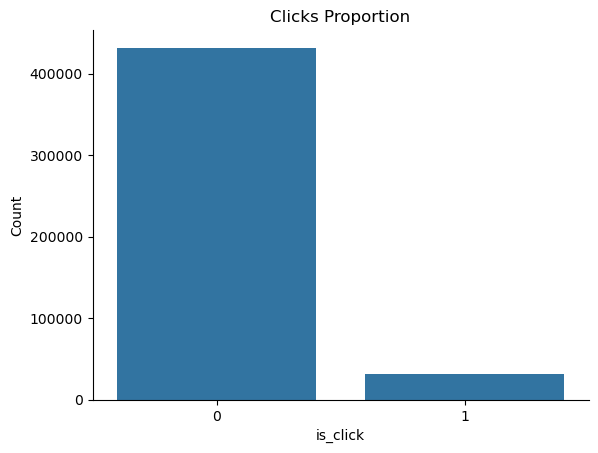

In [18]:
click_counts = df['is_click'].value_counts()
sns.barplot(x=click_counts.index, y=click_counts.values)
plt.xlabel('is_click')
plt.ylabel('Count')
plt.title('Clicks Proportion')
sns.despine(top=True)
plt.show()

Text(0.5, 1.0, 'Number of clicks')

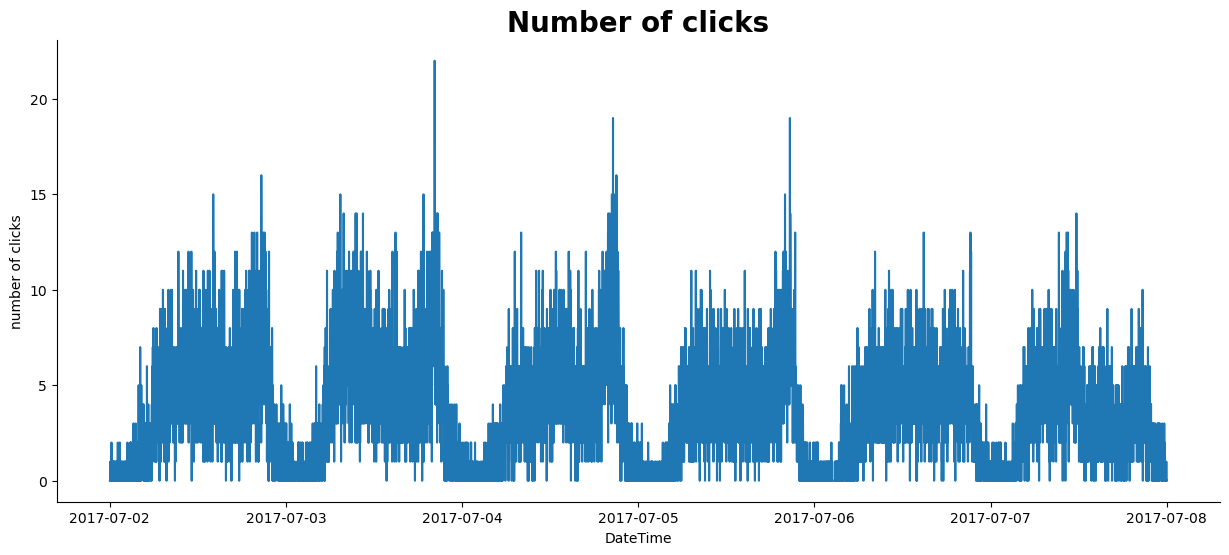

In [24]:
temp_df = df.groupby(['DateTime'],as_index=False)['is_click'].sum().rename(columns={'is_click':'number of clicks'})
plt.figure(figsize=(15,6))
fig = sns.lineplot(x=temp_df['DateTime'],y=temp_df['number of clicks'])
for s in ['top','right']:
    fig.spines[s].set_visible(False)
fig.set_title('Number of clicks',fontsize=20,fontweight='bold')

Text(0.5, 1.0, 'Number of clicks')

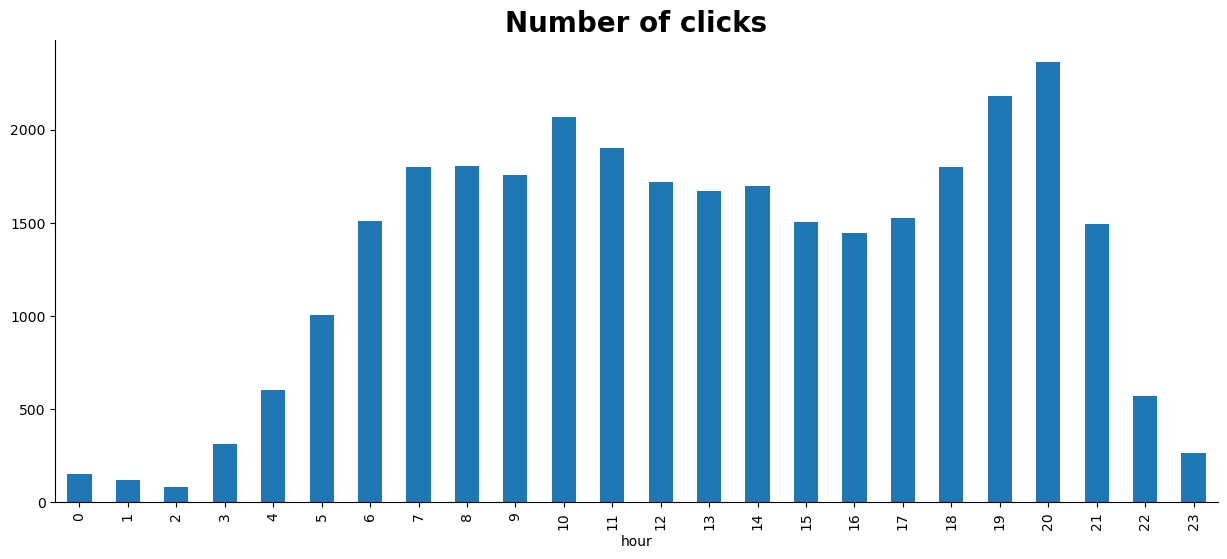

In [25]:
plt.figure(figsize=(15,6))
fig = df.groupby(['hour'])['is_click'].sum().plot(kind='bar')
for s in ['top','right']:
    fig.spines[s].set_visible(False)
fig.set_title('Number of clicks',fontsize=20,fontweight='bold')

## Machine Learning

In [26]:
df = df.sort_values('DateTime')

In [27]:
df.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,gender_encoding,Date,hour
0,140690,2017-07-02 00:00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0,0,2017-07-02,0
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0,0,2017-07-02,0
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0,0,2017-07-02,0
3,464848,2017-07-02 00:00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0,1,2017-07-02,0
4,90569,2017-07-02 00:01:00,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0,1,2017-07-02,0


I have created a class to handle the preprocessing and splitting datasets for training, validation and testing. This takes care of handling the null values and encoding categorical columns. This class also has certain functions for feature engineering. Initially I won't apply any feature engineering.

In [28]:
class Preprocessor:
    def __init__(self, df):
        self.df = df
        self.columns_to_encode = None
        self.encoder_dictionary = {}
        
    def __call__(self, columns_to_encode, encoding_type, train_test_split, feature_engineer):
        
        self.columns_to_encode = columns_to_encode.copy()
        self.encoding_type = encoding_type
        self.train_test_split = train_test_split
        self.feature_engineer = feature_engineer
        
        self.df = self.df.dropna(subset=['session_id','DateTime','user_id','is_click'])
        
        self.df = self.df.drop_duplicates(subset=['DateTime', 'user_id', 'product', 'campaign_id',
       'webpage_id', 'product_category_1', 'product_category_2',
       'user_group_id', 'gender', 'age_level', 'user_depth',
       'city_development_index', 'is_click'])
        
        self.df['DateTime'] = pd.to_datetime(self.df['DateTime'])
        self.df['hour'] = self.df['DateTime'].dt.hour
        
        self.df['time_of_day'] = self.df['hour'].apply(self.find_time_of_day)
        
        for col in self.df.select_dtypes(include='object').columns:
            self.df[col] = self.df[col].fillna(self.df[col].mode().values[0])
            
        for col in self.df.select_dtypes(include=['int','float']).columns:
            self.df[col] = self.df[col].fillna(self.df[col].median())
            
        if feature_engineer==True:
            temp_results = self.df.groupby(['user_id']).apply(self.find_most_clicked_product)
            temp_results = temp_results.reset_index()
            self.df = self.df.merge(temp_results[['user_id','session_id','most_recent_clicked_product']],on=['user_id','session_id'],how='left')

            temp_results = self.df.groupby(['user_id']).apply(self.find_most_clicked_webpage)
            temp_results = temp_results.reset_index()
            self.df = self.df.merge(temp_results[['user_id','session_id','most_recent_clicked_webpage']],on=['user_id','session_id'],how='left')
        
        if self.encoding_type!='target':
            self.df['gender_encoding'] = self.df['gender'].replace({'Female':0,'Male':1})
            self.columns_to_encode.remove('gender')
            
        if self.train_test_split==True:
            self.train = self.df[self.df['DateTime']<'2017-07-06']
            self.validation = self.df[(self.df['DateTime']>='2017-07-06')&(self.df['DateTime']<'2017-07-07')]
            self.test = self.df[(self.df['DateTime']>='2017-07-07')]

            self.encoding()
            
            if self.feature_engineer==True:
                self.train['most_recent_clicked_product_encoding'] = self.train['most_recent_clicked_product'].replace(self.encoder_dictionary['product'])
                self.validation['most_recent_clicked_product_encoding'] = self.validation['most_recent_clicked_product'].replace(self.encoder_dictionary['product'])
                self.test['most_recent_clicked_product_encoding'] = self.test['most_recent_clicked_product'].replace(self.encoder_dictionary['product'])
                
                self.train['most_recent_clicked_webpage_encoding'] = self.train['most_recent_clicked_webpage'].replace(self.encoder_dictionary['webpage_id'])
                self.validation['most_recent_clicked_webpage_encoding'] = self.validation['most_recent_clicked_webpage'].replace(self.encoder_dictionary['webpage_id'])
                self.test['most_recent_clicked_webpage_encoding'] = self.test['most_recent_clicked_webpage'].replace(self.encoder_dictionary['webpage_id'])

            return self.train,self.validation,self.test,self.encoder_dictionary
        
        else:
            self.encoding()
            
            if self.feature_engineer==True:
                self.df['most_recent_clicked_product_encoding'] = self.df['most_recent_clicked_product'].replace(self.encoder_dictionary['product'])
                self.df['most_recent_clicked_webpage_encoding'] = self.df['most_recent_clicked_webpage'].replace(self.encoder_dictionary['webpage_id'])

            return self.df, self.encoder_dictionary
            
    def encoding(self):
        if self.encoding_type=='label':
            for col in self.columns_to_encode:
                le = LabelEncoder()
                if self.train_test_split == True:
                    self.train[f'{col}_encoding'] = le.fit_transform(self.train[col])
                    self.validation[f'{col}_encoding'] = le.transform(self.validation[col])
                    self.test[f'{col}_encoding'] = le.transform(self.test[col])
                else:
                    self.df[f'{col}_encoding'] = le.fit_transform(self.df[col])
                self.encoder_dictionary[col] = {label: encoded_value for label, encoded_value in zip(le.classes_, le.transform(le.classes_))}
                
        if self.encoding_type=='target':
            for col in self.columns_to_encode:
                te = TargetEncoder()
                if self.train_test_split == True:
                    self.train[f'{col}_encoding'] = te.fit_transform(self.train[[col]],self.train[['is_click']])
                    self.validation[f'{col}_encoding'] = te.transform(self.validation[[col]])
                    self.test[f'{col}_encoding'] = te.transform(self.test[[col]])
                else:
                    self.df[f'{col}_encoding'] = te.fit_transform(self.df[col])
                self.encoder_dictionary[col] = {label: encoded_value for label, encoded_value in zip(le.classes_, le.transform(le.classes_))}
                
        if self.encoding_type=='custom':
            for col in self.columns_to_encode:
                if self.train_test_split==True:
                    mapping = self.find_ordinal_mapping(col,self.train)
                    self.train[f'{col}_encoding'] = self.train[col].replace(mapping)
                    self.validation[f'{col}_encoding'] = self.validation[col].replace(mapping)
                    self.test[f'{col}_encoding'] = self.test[col].replace(mapping)
                else:
                    mapping = self.find_ordinal_mapping(col,self.df)
                    self.df[f'{col}_encoding'] = self.df[col].replace(mapping)
                self.encoder_dictionary[col] = mapping

    def find_ordinal_mapping(self,col,tmp_df):
        temp_df = tmp_df.groupby([col],as_index=False).agg(no_of_sessions=('session_id','count'),
                                                no_of_clicks=('is_click','sum'))
        temp_df['ctr'] = temp_df['no_of_clicks']/temp_df['no_of_sessions']
        temp_df = temp_df.sort_values('ctr')
        temp_df = temp_df.reset_index().rename(columns={'index':f'{col}_encoding'})
        temp_mapping = dict(zip(temp_df[col],temp_df[f'{col}_encoding']))
        return temp_mapping
    
    def find_most_clicked_product(self,group):
        rolling_window = group.rolling(window=24)
        session_ids = []
        products = []
        for win in rolling_window:
            session_ids.append(win.iloc[-1]['session_id'])
            if 1 in win['is_click']:
                products.append(win.groupby(['product'],as_index=False)['is_click'].sum().nlargest(1,'is_click')['product'].values[0])
            else:
                products.append(win['product'].value_counts().nlargest(1).index[0])
        return pd.DataFrame({
            'session_id':session_ids,
            'most_recent_clicked_product':products
                     })
        
    def find_most_clicked_webpage(self,group):
        rolling_window = group.rolling(window=24)
        session_ids = []
        webpage_ids = []
        for win in rolling_window:
            session_ids.append(win.iloc[-1]['session_id'])
            if 1 in win['is_click']:
                webpage_ids.append(win.groupby(['webpage_id'],as_index=False)['is_click'].sum().nlargest(1,'is_click')['webpage_id'].values[0])
            else:
                webpage_ids.append(win['webpage_id'].value_counts().nlargest(1).index[0])
        return pd.DataFrame({
            'session_id':session_ids,
            'most_recent_clicked_webpage':webpage_ids
                     })
    
    
    def find_time_of_day(self,hour):
        if hour>0 and hour<5 or hour>22:
            return 'night'
        elif hour>=5 and hour<10:
            return 'early-morning'
        elif hour>=10 and hour<=13:
            return 'morning'
        elif hour>13 and hour<18:
            return 'afternoon'
        else:
            return 'evening'

In [29]:
preprocessor = Preprocessor(df)

columns_to_encode = ['product','gender','age_level','time_of_day','product_category_1','webpage_id','campaign_id']
encoding_type = 'label'
train_test_split = True
feature_engineer = False

train, validation, test, encoder_dictionary = preprocessor(columns_to_encode, encoding_type, train_test_split, feature_engineer)

In [31]:
train.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,...,most_recent_clicked_product,most_recent_clicked_webpage,product_encoding,age_level_encoding,time_of_day_encoding,product_category_1_encoding,webpage_id_encoding,campaign_id_encoding,most_recent_clicked_product_encoding,most_recent_clicked_webpage_encoding
0,140690,2017-07-02 00:00:00,858557,C,359520,13787,4,146115.0,10.0,Female,...,C,13787,2,4,2,3,3,4,2,3
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,146115.0,8.0,Female,...,C,11085,2,2,2,4,2,2,2,2
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,146115.0,8.0,Female,...,C,11085,2,2,2,3,3,4,2,2
3,464848,2017-07-02 00:00:00,1097446,I,359520,13787,3,146115.0,3.0,Male,...,I,13787,8,3,2,2,3,4,8,3
4,90569,2017-07-02 00:01:00,663656,C,405490,60305,3,146115.0,2.0,Male,...,C,60305,2,2,2,2,8,8,2,8


Here I am not using the most_recent_clicked_product_encoding and most_recent_clicked_webpage_encoding columns.

In [32]:
features_to_consider = ['is_click','gender_encoding', 'product_category_1_encoding','product_encoding', 
                        'campaign_id_encoding', 'age_level_encoding','webpage_id_encoding', 
                        'time_of_day_encoding']

training_dataset = train[features_to_consider]
validation_dataset = validation[features_to_consider]
testing_dataset = test[features_to_consider]

The percentage of number of positives (ad clicked) is very small compared to the percentage of number of negatives (ad not clicked). This is a case of unbalanced dataset. To handle this I have done downsampling i.e I have reduced the size of the negative class samples to equal the size of the positive class samples. We can also do the vice-versa i.e upsampling to balance the dataset.

In [34]:
def resample_training_dataset(df, target='is_click', resampling_type='downsample'):
    '''
    Receives the dataset and the sampling technique
    
    Performs the sampling and returns the balanced dataset
    '''
    majority_class = df[df[target] == 0]
    minority_class = df[df[target] == 1]

    if resampling_type=='downsample':
        tmp = resample(majority_class,
                       replace=False,  
                       n_samples=len(minority_class),  
                       random_state=42) 
        
        resampled_df = pd.concat([tmp, minority_class],axis=0)
        
    elif resampling_type=='upsample':
        tmp = resample(minority_class,
                       replace=True,
                       n_samples=len(majority_class),  
                       random_state=42) 
        
        resampled_df = pd.concat([tmp, majority_class],axis=0)

    resampled_df = resampled_df.sample(frac=1, random_state=42)

    return resampled_df

training_dataset = resample_training_dataset(training_dataset)

In [35]:
training_dataset['is_click'].value_counts()

is_click
1    22083
0    22083
Name: count, dtype: int64

### Building models

I had experimented with different models and decided to use XGBoost for deploying. Compared to other techniques XGBoost had a better recall in identifying positive classes (The truth is there were many AWS resources that demonstrated how to XGBoost in Sagemaker. Hence went with XGBoost.)

In [36]:
lg = LogisticRegression()
lg.fit(training_dataset.drop('is_click',axis=1),training_dataset['is_click'])
pred_val = lg.predict(validation_dataset.drop('is_click',axis=1))

In [37]:
print(classification_report(validation_dataset['is_click'],pred_val))

              precision    recall  f1-score   support

           0       0.94      0.49      0.65     70578
           1       0.07      0.52      0.12      4796

    accuracy                           0.50     75374
   macro avg       0.50      0.51      0.38     75374
weighted avg       0.88      0.50      0.61     75374



In [38]:
ran = RandomForestClassifier(n_estimators=500)
ran.fit(training_dataset.drop('is_click',axis=1),training_dataset['is_click'])
pred_val = ran.predict(validation_dataset.drop('is_click',axis=1))

In [39]:
print(classification_report(validation_dataset['is_click'],pred_val))

              precision    recall  f1-score   support

           0       0.94      0.52      0.67     70578
           1       0.07      0.53      0.12      4796

    accuracy                           0.52     75374
   macro avg       0.51      0.53      0.40     75374
weighted avg       0.89      0.52      0.64     75374



In [40]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators=1000, random_state=42)
xgb_classifier.fit(training_dataset.drop('is_click',axis=1),training_dataset['is_click'])
pred_xgb = xgb_classifier.predict(validation_dataset.drop('is_click',axis=1))

In [41]:
print(classification_report(validation_dataset['is_click'],pred_xgb))

              precision    recall  f1-score   support

           0       0.94      0.53      0.68     70578
           1       0.07      0.54      0.13      4796

    accuracy                           0.53     75374
   macro avg       0.51      0.53      0.40     75374
weighted avg       0.89      0.53      0.64     75374



We have decided to use XGBoost algorithm. Sagemaker offers two ways in which we can use XGBoost. We can use it as a framework or built-in algorithm. Lets use the framework option. The difference between the two methods is in framework option we can use our customized training scripts while this is not possible in the other option.

The must needed step in both the cases is the training and validation datasets should be present in the S3 bucket. Also, Sagemaker supports multiple file type formats. We will be using csv. The csv file should not contain headers and the target column should always be the first column followed by the rest. This is the reason why 'is_click' (target column) is at the first position in both training and validation datasets.

Refer here for more information on how to use XGBoost: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html

### Preparing datasets for Sagemaker XGBoost algorithm

In [42]:
def convert_dataframe_to_csv(df,name):
    name=name+'.csv'
    df.to_csv(name,index=False,header=False)
    
convert_dataframe_to_csv(training_dataset,'training')
convert_dataframe_to_csv(validation_dataset,'validation')

In [43]:
# upload the csv file to s3 using Sagemaker session
# The training and validation datasets should be present in S3 bucket 
# which will be used by Sagemaker for training the models
session.upload_data('training.csv',
                    bucket=bucket,
                    key_prefix='ctr_prediction/train')

session.upload_data('validation.csv',
                    bucket=bucket,
                    key_prefix='ctr_prediction/validation')

's3://sagemaker-us-east-1-995541965594/ctr_prediction/validation/validation.csv'

At the time of training the model, the datasets are fetched from the S3 bucket and the python script is invoked where we train our XGBoost model, convert the model into pickle file and store it in the S3 path specified by the output_path paramater. The instance_type parameter spcifies the instance we want to use for training the model.

### Building XGBoost model

In [44]:
hyperparams = {
#     "max_depth": "10",
#     "eta": "0.005",
#     "gamma": "4",
#     "min_child_weight": "6",
#     "subsample": "0.7",
    "objective": "binary:logistic",
    "num_round": "1000",
}

prefix = "ctr_prediction"
instance_type = "ml.m5.xlarge"
output_path = "s3://{}/{}/{}/output".format(bucket, prefix, "xgboost-output")
content_type = "text/csv"

I have also enabled spot instance training which will help in a significant reduction of costs. 

In [45]:
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost.estimator import XGBoost

script_path = "xgb_train.py"

xgb_script_mode_estimator = XGBoost(
    entry_point=script_path,
    framework_version="1.7-1",  # framework_version is mandatory
    hyperparameters=hyperparams,
    role=role,
    instance_count=2,
    instance_type=instance_type,
    output_path=output_path,
    use_spot_instances=True,
    max_run=3600,
    max_wait=7200
)

In the below code I have specified a parameter named distribution. This helps with distributed training. Also, previously while defining the model, I have set the instance count to 2 to achieve this objective.

### Training

In [46]:
train_input = TrainingInput(
    "s3://{}/{}/{}/".format(bucket, prefix, "train"), content_type=content_type, distribution='ShardedByS3Key'
)
validation_input = TrainingInput(
    "s3://{}/{}/{}/".format(bucket, prefix, "validation"), content_type=content_type, distribution='ShardedByS3Key'
)

xgb_script_mode_estimator.fit({"train": train_input, "validation": validation_input})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-05-02-08-09-08-901


2024-05-02 08:09:09 Starting - Starting the training job...
2024-05-02 08:09:25 Starting - Preparing the instances for training...
2024-05-02 08:09:56 Downloading - Downloading input data...
2024-05-02 08:10:27 Downloading - Downloading the training image...
2024-05-02 08:11:02 Training - Training image download completed. Training in progress....[2024-05-02 08:11:10.472 ip-10-2-203-230.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-05-02 08:11:10.493 ip-10-2-203-230.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-05-02:08:11:10:INFO] Imported framework sagemaker_xgboost_container.training
[2024-05-02:08:11:10:INFO] No GPUs detected (normal if no gpus installed)
[2024-05-02:08:11:10:INFO] Invoking user training script.
[2024-05-02:08:11:11:INFO] Module xgb_train does not provide a setup.py. 
Generating setup.py
[2024-05-02:08:11:11:INFO] Generating setup.cfg
[2024-05-02:08:11:11:INFO] Generating MANIFEST.in
[2024-05-02:08

### Deploying XGBoost model as endpoint

In [47]:
from sagemaker.serializers import CSVSerializer

predictor = xgb_script_mode_estimator.deploy(
    initial_instance_count=1, instance_type="ml.m5.xlarge", serializer = CSVSerializer())

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-05-02-08-43-25-957
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-05-02-08-43-25-957
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-05-02-08-43-25-957


-----!

In [49]:
predictor.endpoint_name

'sagemaker-xgboost-2024-05-02-08-43-25-957'

### Making predictions using endpoint

In [50]:
def prediction(endpoint_name,serialized_input):
    sagemaker_runtime = boto3.client('sagemaker-runtime',region_name='us-east-1')

    response = sagemaker_runtime.invoke_endpoint(
        EndpointName=endpoint_name, ContentType='text/csv', Body=serialized_input
    )

    result = response["Body"].read().decode("ascii")
#     probability = json.loads(result)[0]
    
    return json.loads(result)

In [51]:
serialized_input = CSVSerializer().serialize(validation_dataset.sample(1).values[:,1:])
#serialized_input = ','.join(map(str,validation_dataset.sample(1).values[0]))
serialized_input

'1,3,7,4,3,3,1'

In [52]:
print(prediction(predictor.endpoint_name,serialized_input))

[0.482339084148407]


In [132]:
serialized_input = CSVSerializer().serialize(validation_dataset.sample(1).values[:,1:])
print(prediction(predictor.endpoint_name,serialized_input))

[0.6092855930328369]


### Validation set results

In [53]:
serialized_input = CSVSerializer().serialize(validation_dataset.sample(len(validation_dataset)).values[:,1:])

In [54]:
validation_probabilities = prediction(predictor.endpoint_name,serialized_input)
validation_predictions = [1 if x>0.5 else 0 for x in validation_probabilities]

In [55]:
print(confusion_matrix(validation_dataset['is_click'],validation_predictions))

[[36823 33755]
 [ 2505  2291]]


In [56]:
print(classification_report(validation_dataset['is_click'],validation_predictions))

              precision    recall  f1-score   support

           0       0.94      0.52      0.67     70578
           1       0.06      0.48      0.11      4796

    accuracy                           0.52     75374
   macro avg       0.50      0.50      0.39     75374
weighted avg       0.88      0.52      0.63     75374



### Testing set results

In [58]:
serialized_input = CSVSerializer().serialize(testing_dataset.sample(len(testing_dataset)).values[:,1:])

In [59]:
testing_probabilities = prediction(predictor.endpoint_name,serialized_input)
testing_predictions = [1 if x>0.5 else 0 for x in testing_probabilities]

In [61]:
print(classification_report(testing_dataset['is_click'],testing_predictions))

              precision    recall  f1-score   support

           0       0.94      0.50      0.65     64784
           1       0.06      0.49      0.11      4373

    accuracy                           0.50     69157
   macro avg       0.50      0.49      0.38     69157
weighted avg       0.88      0.50      0.62     69157



## Predicting using API endpoint

The REST API endpoint was created using API Gateway

In [140]:
train.sample(1)[['user_id','gender','product_category_1','product','campaign_id','age_level','webpage_id','hour']].values

array([[421860, 'Male', 3, 'C', 405490, 2.0, 60305, 14]], dtype=object)

In [141]:
import requests

api_endpoint = "https://uu4zcyvmw4.execute-api.us-east-1.amazonaws.com/XGBoostModel"

data = {"data":[[421860, 'Male', 3, 'C', 405490, 2.0, 60305, 14]]}

response = requests.post(url=api_endpoint,json=data)

In [142]:
response.json()

{'statusCode': 200, 'prediction': ['Clicked']}

## Building models using engineered features

Let's re-build the model using the feature 'most_recent_clicked_product_encoding', retrain and deploy the XGBoost model.

In [ ]:
preprocessor = Preprocessor(df)

columns_to_encode = ['product','gender','age_level','time_of_day','product_category_1','webpage_id','campaign_id']
encoding_type = 'label'
train_test_split = True
feature_engineer = True

train, validation, test, encoder_dictionary = preprocessor(columns_to_encode, encoding_type, train_test_split, feature_engineer)

In [62]:
train.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,...,most_recent_clicked_product,most_recent_clicked_webpage,product_encoding,age_level_encoding,time_of_day_encoding,product_category_1_encoding,webpage_id_encoding,campaign_id_encoding,most_recent_clicked_product_encoding,most_recent_clicked_webpage_encoding
0,140690,2017-07-02 00:00:00,858557,C,359520,13787,4,146115.0,10.0,Female,...,C,13787,2,4,2,3,3,4,2,3
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,146115.0,8.0,Female,...,C,11085,2,2,2,4,2,2,2,2
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,146115.0,8.0,Female,...,C,11085,2,2,2,3,3,4,2,2
3,464848,2017-07-02 00:00:00,1097446,I,359520,13787,3,146115.0,3.0,Male,...,I,13787,8,3,2,2,3,4,8,3
4,90569,2017-07-02 00:01:00,663656,C,405490,60305,3,146115.0,2.0,Male,...,C,60305,2,2,2,2,8,8,2,8


In [76]:
features_to_consider = ['is_click','gender_encoding', 'product_category_1_encoding','product_encoding', 
                        'campaign_id_encoding', 'age_level_encoding','webpage_id_encoding', 
                        'time_of_day_encoding','most_recent_clicked_product_encoding']

training_dataset = train[features_to_consider]
validation_dataset = validation[features_to_consider]
testing_dataset = test[features_to_consider]

In [77]:
training_dataset = resample_training_dataset(training_dataset)

In [78]:
convert_dataframe_to_csv(training_dataset,'training_updated')
convert_dataframe_to_csv(validation_dataset,'validation_updated')

In [79]:
# upload the csv file to s3 using Sagemaker session
# The training and validation datasets should be present in S3 bucket 
# which will be used by Sagemaker for training the models
session.upload_data('training_updated.csv',
                    bucket=bucket,
                    key_prefix='ctr_prediction/train_updated')

session.upload_data('validation_updated.csv',
                    bucket=bucket,
                    key_prefix='ctr_prediction/validation_updated')

's3://sagemaker-us-east-1-995541965594/ctr_prediction/validation_updated/validation_updated.csv'

In [80]:
train_input = TrainingInput(
    "s3://{}/{}/{}/".format(bucket, prefix, "train_updated"), content_type=content_type
)
validation_input = TrainingInput(
    "s3://{}/{}/{}/".format(bucket, prefix, "validation_updated"), content_type=content_type
)

xgb_script_mode_estimator.fit({"train": train_input, "validation": validation_input})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-05-02-10-43-07-505


2024-05-02 10:43:07 Starting - Starting the training job...
2024-05-02 10:43:23 Starting - Preparing the instances for training...
2024-05-02 10:44:03 Downloading - Downloading input data...
2024-05-02 10:44:33 Downloading - Downloading the training image......
2024-05-02 10:45:09 Training - Training image download completed. Training in progress.[2024-05-02 10:45:16.900 ip-10-0-64-199.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-05-02 10:45:16.927 ip-10-0-64-199.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-05-02:10:45:17:INFO] Imported framework sagemaker_xgboost_container.training
[2024-05-02:10:45:17:INFO] No GPUs detected (normal if no gpus installed)
[2024-05-02:10:45:17:INFO] Invoking user training script.
[2024-05-02:10:45:17:INFO] Module xgb_train does not provide a setup.py. 
Generating setup.py
[2024-05-02:10:45:17:INFO] Generating setup.cfg
[2024-05-02:10:45:17:INFO] Generating MANIFEST.in
[2024-05-02:10:4

### Deploying model

In [81]:
from sagemaker.serializers import CSVSerializer

predictor = xgb_script_mode_estimator.deploy(
    initial_instance_count=1, instance_type="ml.m5.xlarge", serializer = CSVSerializer())

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-05-02-10-46-21-135
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-05-02-10-46-21-135
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-05-02-10-46-21-135


------!

### Validation set results

In [84]:
serialized_input = CSVSerializer().serialize(validation_dataset.sample(len(validation_dataset)).values[:,1:])
validation_probabilities = prediction(predictor.endpoint_name,serialized_input)
validation_predictions = [1 if x>0.5 else 0 for x in validation_probabilities]

In [85]:
print(confusion_matrix(validation_dataset['is_click'],validation_predictions))

[[34944 35634]
 [ 2398  2398]]


In [86]:
print(classification_report(validation_dataset['is_click'],validation_predictions))

              precision    recall  f1-score   support

           0       0.94      0.50      0.65     70578
           1       0.06      0.50      0.11      4796

    accuracy                           0.50     75374
   macro avg       0.50      0.50      0.38     75374
weighted avg       0.88      0.50      0.61     75374



### Testing set results

In [87]:
serialized_input = CSVSerializer().serialize(testing_dataset.sample(len(testing_dataset)).values[:,1:])

In [88]:
testing_probabilities = prediction(predictor.endpoint_name,serialized_input)
testing_predictions = [1 if x>0.5 else 0 for x in testing_probabilities]

In [89]:
print(classification_report(testing_dataset['is_click'],testing_predictions))

              precision    recall  f1-score   support

           0       0.94      0.49      0.64     64784
           1       0.06      0.51      0.11      4373

    accuracy                           0.49     69157
   macro avg       0.50      0.50      0.38     69157
weighted avg       0.88      0.49      0.61     69157



Using the engineered features has provided a slight increase to precision and recall scores on the validation and testing datasets.

## Notes

Every product is associated with multiple campaigns

Dataset link https://www.kaggle.com/datasets/arashnic/ctr-in-advertisement/code